# Eigenfaces a

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from numpy.linalg import matrix_rank
from numpy.linalg import inv
import time

mat_content = sio.loadmat('face.mat')

face_data = mat_content['X']
face_id = mat_content['l']

print(face_data)
print(face_data.shape)

print(face_id)
print(face_id.shape)

[[106 130 191 ...  70 183  77]
 [103 129 185 ...  62 250  72]
 [103 130 174 ...  83 163  68]
 ...
 [ 37  40  22 ...  87 102  93]
 [ 36  36  19 ...  89  95 103]
 [ 41  35  17 ...  94 106 110]]
(2576, 520)
[[ 1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  3  3  3  3
   3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5
   5  5  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  8  8
   8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
  10 10 10 10 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12
  13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 15 15 15 15
  15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
  17 17 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 20 20
  20 20 20 20 20 20 20 20 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22
  22 22 22 22 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24
  25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 

In [2]:
# Split data set
# Train_id is the index of each train data in the total data set, test_id the same

from sklearn.model_selection import train_test_split

indices = np.arange(len(face_id[0]))
train_data, test_data, train_id, test_id = train_test_split(face_data.T, indices, test_size = 0.2)
train_data = train_data.T
test_data = test_data.T

print(train_data)
print(train_data.shape)
print(test_data)
print(test_data.shape)

[[ 86 134 122 ...  57 127 190]
 [ 86 136 131 ...  60 138 188]
 [ 87 138 141 ...  57 139 184]
 ...
 [238  65  85 ... 116  64  44]
 [226  61  86 ... 123  60  41]
 [221  60  68 ... 119  60  40]]
(2576, 416)
[[124 162 190 ...  91 218  92]
 [146 174 167 ...  92 222  94]
 [147 182 143 ...  88 223  96]
 ...
 [ 55 117  61 ...  96  72  40]
 [ 69 115  73 ... 111 157  38]
 [ 74 110 128 ... 107 167  39]]
(2576, 104)


In [3]:
# Count the number of face images for each person 
# in the train and test set after randomly split

train_label = face_id[0,train_id]
unique_train, counts_train = np.unique(train_label, return_counts=True)
dict(zip(unique_train, counts_train))

#test_label = face_id[0,test_id]
#unique_test, counts_test = np.unique(test_label, return_counts=True)
#dict(zip(unique_test, counts_test))

#print(unique_train)
#print(train_label)
#print(counts_train)


{1: 7,
 2: 7,
 3: 8,
 4: 9,
 5: 8,
 6: 7,
 7: 10,
 8: 7,
 9: 8,
 10: 9,
 11: 8,
 12: 8,
 13: 6,
 14: 9,
 15: 6,
 16: 9,
 17: 6,
 18: 7,
 19: 9,
 20: 6,
 21: 9,
 22: 8,
 23: 9,
 24: 9,
 25: 10,
 26: 9,
 27: 7,
 28: 5,
 29: 8,
 30: 7,
 31: 8,
 32: 7,
 33: 10,
 34: 7,
 35: 8,
 36: 8,
 37: 8,
 38: 7,
 39: 9,
 40: 6,
 41: 8,
 42: 9,
 43: 8,
 44: 10,
 45: 5,
 46: 10,
 47: 9,
 48: 7,
 49: 9,
 50: 9,
 51: 10,
 52: 9}

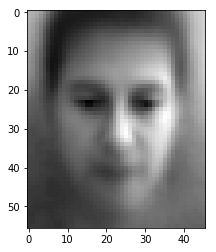

In [4]:
# Compute average face vector

num_train = len(train_data[0])

avg_face = train_data.mean(axis=1)

plt.imshow(np.reshape(avg_face,(46,56)).T, cmap = 'gist_gray')

#print(train_data.shape)
#print(num_train)

In [5]:
# Compute covariance matrix without low-dimensional compution

num_pix = len(train_data)

A = train_data - avg_face.reshape(num_pix,1)
S = (A.dot(A.T)) / num_train

#print(num_pix)

# PCA-LDA Ensemble 

In [6]:
import random

T = 3
M0 = 200
M1 = 10
# Mpca = M0 + M1 should not exceed 
M_lda = 50
n_sample = 7 # number of samples per class
M_pca = 200

# Generate random subspaces 
def rand_subspace(eigvecs,eigvals):
    subspace = eigvecs[:,np.argsort(-eigvals)[ : M0]]
    #print(len(eigvals))
    index = (np.argsort(eigvals)[ : len(eigvals) - M0]).tolist()
    rand_index = random.sample(index, M1)  
    subspace = np.concatenate((subspace, eigvecs[:,rand_index]), axis=1)
    return subspace

# Bagging (from every class)
def rand_sample(sorted_train_data,sorted_train_label,counts_train):
    sample = list()
    label = list()
    current_index = 0
    for idx,cnt in enumerate(counts_train):
        for j in range(n_sample):
            index = random.randrange(current_index, current_index + cnt, 1)
            sample.append(sorted_train_data[:,index])
            label.append(sorted_train_label[index])
        current_index += cnt
    
    return ((np.asarray(sample)).T), np.asarray(label)

# Generate eigenspace of data set using PCA
def eigspace_generator_ensemble(data):
    num_train = len(data[0])
    avg_face = data.mean(axis=1)
    num_pix = len(data)
    A = data - avg_face.reshape(num_pix,1)
    S_low_dim = ((A.T).dot(A)) / num_train
    eigvals_low_dim, eigvecs_low_dim = np.linalg.eig(S_low_dim)
    eigvals_low_dim = eigvals_low_dim.real
    eigvecs_low_dim = eigvecs_low_dim.real
    nonzero_eigvals_low_dim = eigvals_low_dim[abs(eigvals_low_dim) >= 1e-7]
    eigvecs_nonzero_eigvals_low_dim = eigvecs_low_dim[:,abs(eigvals_low_dim) >= 1e-7]
    eigfaces_low_dim_unnormalized = A.dot(eigvecs_nonzero_eigvals_low_dim[:,np.argsort(-nonzero_eigvals_low_dim)[:M_pca]]) 
    eigfaces_low_dim = (preprocessing.normalize(eigfaces_low_dim_unnormalized.T, norm='l2')).T
    return eigfaces_low_dim, nonzero_eigvals_low_dim, A


# Committe Machine with Bagging

In [7]:
sorted_train_data = train_data[:,np.argsort(train_label)]
sorted_train_label = train_label[np.argsort(train_label)]

In [8]:
def lda_rand_data(train_data,train_label,test_data): # test_data single column vector

    avg_face = train_data.mean(axis=1)
    num_pix = len(train_data)
    unique_train, counts_train = np.unique(train_label, return_counts=True)
    c = max(train_label) # number of classes
    M = np.zeros((num_pix, c))

    list_Sw = [] # Each element of list_Sw contains the with-in scatter matrix of the i+1th class
    
    current_index = 0;
    for idx in range(c):
        X = train_data[:,current_index : current_index + n_sample]
        M[:,idx] = (X.mean(axis=1))
        A_Sw =  X - M[:,idx].reshape(num_pix,1)
        Sw = A_Sw.dot(A_Sw.T)
        list_Sw.append(Sw)
        current_index += n_sample
    
    # Compute between-scatter matrix Sb

    A_Sb =  M - avg_face.reshape(num_pix,1)
    Sb = A_Sb.dot(A_Sb.T)

    # Compute within-scatter matrix Sw
    Sw = np.zeros((num_pix,num_pix))

    for i in range(c):
        Sw += list_Sw[i]

    # PCA to reduce dimenstion to Mpca
    
    W_pca, eigenvalues, A = eigspace_generator_ensemble(train_data)
    
    Sb_pca = (W_pca.T).dot(Sb.dot(W_pca))
    Sw_pca = (W_pca.T).dot(Sw.dot(W_pca))
    
    eigvals_lda, eigvecs_lda = np.linalg.eig((inv(Sw_pca)).dot(Sb_pca))
    eigvals_lda = eigvals_lda.real
    eigvecs_lda = eigvecs_lda.real

    nonzero_eigvals_lda = eigvals_lda[abs(eigvals_lda) >= 1e-7]
    eigvecs_nonzero_eigvals_lda = eigvecs_lda[:,abs(eigvals_lda) >= 1e-7]
    
    sorted_index_lda = np.argsort(-nonzero_eigvals_lda)[:M_lda]

    W_lda = eigvecs_nonzero_eigvals_lda[:,sorted_index_lda]

    # NN-classification

    W_train_pca = (A.T).dot(W_pca)
    W_train_lda = (W_train_pca).dot(W_lda)
    sorted_W_train_lda = W_train_lda[np.argsort(train_label),:]

    A_test_lda = test_data.reshape(num_pix,1) - avg_face.reshape(num_pix,1)

    # Project test data to PCA subspace
    W_test_pca = (A_test_lda.T).dot(W_pca) # Coordinates (row vector) on PCA subspace
    # Project test data to LDA subspace
    W_test_lda = (W_test_pca).dot(W_lda) # Coordinates (row vector) on LDA subspace
    
    distance = np.linalg.norm(W_test_lda - sorted_W_train_lda, axis=1) # row vector containing Euclidiean distance to each tranining data
   
        
    min_distance = []
    current_index = 0;
    for idx,cnt in enumerate(counts_train):
        distance = distance.reshape(len(distance),1)
        min_distance.append(min(distance[current_index : current_index + cnt,:]))
        current_index += cnt
    
    post_distribution = (min_distance / sum(min_distance)) 
    
    return post_distribution

In [9]:
results_error = test_results_ensemble - true_results

success_rate = np.count_nonzero(results_error == 0) / len(results_error)
print(success_rate)

NameError: name 'test_results_ensemble' is not defined

In [10]:
S = []
S_label = []

for i in range(T):
    data,label = rand_sample(sorted_train_data,sorted_train_label,counts_train)
    S.append(data) # generate T random training subset
    S_label.append(label)

    
test_results_ensemble = []
for i in range(len(test_data[0])):
    post_distribution = [] # each column vector contains posterior distribution of each model
    
    for j in range(T):
        post_distribution.append(lda_rand_data(S[j],S_label[j],test_data[:,i])) # perform lda on each subspaces learnt

    index = np.argmin(sum(post_distribution) / (T)) + 1
    test_results_ensemble.append(index)
    print(test_results_ensemble)
    
print(test_results_ensemble)

[34]
[34, 43]
[34, 43, 15]
[34, 43, 15, 16]
[34, 43, 15, 16, 38]
[34, 43, 15, 16, 38, 34]
[34, 43, 15, 16, 38, 34, 18]
[34, 43, 15, 16, 38, 34, 18, 5]
[34, 43, 15, 16, 38, 34, 18, 5, 4]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20, 8]
[34, 43, 15, 16, 38, 

[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20, 8, 45, 50, 51, 11, 4, 16, 35, 9, 31, 4, 32, 4, 22, 39, 4, 16, 16, 23, 32, 32, 20, 42, 28, 4, 12, 16, 40, 27, 13, 16, 16, 2, 36, 17, 6, 30, 29, 8, 17, 4, 31, 37, 19, 14, 16]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20, 8, 45, 50, 51, 11, 4, 16, 35, 9, 31, 4, 32, 4, 22, 39, 4, 16, 16, 23, 32, 32, 20, 42, 28, 4, 12, 16, 40, 27, 13, 16, 16, 2, 36, 17, 6, 30, 29, 8, 17, 4, 31, 37, 19, 14, 16, 52]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20, 8, 45, 50, 51, 11, 4, 16, 35, 9, 31, 4, 32, 4, 22, 39, 4, 16, 16, 23, 32, 32, 20, 42, 28, 4, 12, 16, 40, 27, 13, 16, 16, 2, 36, 17, 6, 30, 29, 8, 17, 4, 31, 37, 19, 14, 16, 52, 40]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20, 8, 45, 50, 51, 11, 4, 16, 35, 9, 31, 4, 32, 4, 22, 39, 4, 16, 16, 23, 32, 32, 20, 42, 28, 4, 12, 16, 40, 27, 13, 16, 16, 2, 36, 17, 6, 30, 29, 8, 17,

[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20, 8, 45, 50, 51, 11, 4, 16, 35, 9, 31, 4, 32, 4, 22, 39, 4, 16, 16, 23, 32, 32, 20, 42, 28, 4, 12, 16, 40, 27, 13, 16, 16, 2, 36, 17, 6, 30, 29, 8, 17, 4, 31, 37, 19, 14, 16, 52, 40, 34, 4, 49, 18, 49, 1, 6, 26, 48, 38, 29, 16, 15, 15, 5, 21, 37, 50, 50, 10, 40, 32, 11, 48, 16, 20]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20, 8, 45, 50, 51, 11, 4, 16, 35, 9, 31, 4, 32, 4, 22, 39, 4, 16, 16, 23, 32, 32, 20, 42, 28, 4, 12, 16, 40, 27, 13, 16, 16, 2, 36, 17, 6, 30, 29, 8, 17, 4, 31, 37, 19, 14, 16, 52, 40, 34, 4, 49, 18, 49, 1, 6, 26, 48, 38, 29, 16, 15, 15, 5, 21, 37, 50, 50, 10, 40, 32, 11, 48, 16, 20, 8]
[34, 43, 15, 16, 38, 34, 18, 5, 4, 43, 3, 41, 18, 30, 16, 4, 8, 41, 20, 22, 20, 8, 45, 50, 51, 11, 4, 16, 35, 9, 31, 4, 32, 4, 22, 39, 4, 16, 16, 23, 32, 32, 20, 42, 28, 4, 12, 16, 40, 27, 13, 16, 16, 2, 36, 17, 6, 30, 29, 8, 17, 4, 31, 37, 19, 14, 16, 52, 40, 34, 4, 49, 18,

0.7019230769230769
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


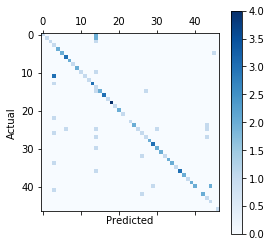

In [22]:
results_error = test_results_ensemble - test_label

success_rate = np.count_nonzero(results_error==0) / len(results_error)
print(success_rate)

cm = confusion_matrix(test_label, test_results_ensemble)

print(cm)
plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
test_label = face_id[0,test_id]
unique_train, counts_train = np.unique(train_label, return_counts=True)
dict(zip(unique_train, counts_train))

{1: 7,
 2: 7,
 3: 8,
 4: 9,
 5: 8,
 6: 7,
 7: 10,
 8: 7,
 9: 8,
 10: 9,
 11: 8,
 12: 8,
 13: 6,
 14: 9,
 15: 6,
 16: 9,
 17: 6,
 18: 7,
 19: 9,
 20: 6,
 21: 9,
 22: 8,
 23: 9,
 24: 9,
 25: 10,
 26: 9,
 27: 7,
 28: 5,
 29: 8,
 30: 7,
 31: 8,
 32: 7,
 33: 10,
 34: 7,
 35: 8,
 36: 8,
 37: 8,
 38: 7,
 39: 9,
 40: 6,
 41: 8,
 42: 9,
 43: 8,
 44: 10,
 45: 5,
 46: 10,
 47: 9,
 48: 7,
 49: 9,
 50: 9,
 51: 10,
 52: 9}

In [19]:
len(test_label)

104

In [16]:
test_results_ensemble

[34,
 43,
 15,
 16,
 38,
 34,
 18,
 5,
 4,
 43,
 3,
 41,
 18,
 30,
 16,
 4,
 8,
 41,
 20,
 22,
 20,
 8,
 45,
 50,
 51,
 11,
 4,
 16,
 35,
 9,
 31,
 4,
 32,
 4,
 22,
 39,
 4,
 16,
 16,
 23,
 32,
 32,
 20,
 42,
 28,
 4,
 12,
 16,
 40,
 27,
 13,
 16,
 16,
 2,
 36,
 17,
 6,
 30,
 29,
 8,
 17,
 4,
 31,
 37,
 19,
 14,
 16,
 52,
 40,
 34,
 4,
 49,
 18,
 49,
 1,
 6,
 26,
 48,
 38,
 29,
 16,
 15,
 15,
 5,
 21,
 37,
 50,
 50,
 10,
 40,
 32,
 11,
 48,
 16,
 20,
 8,
 45,
 16,
 49,
 27,
 35,
 49,
 9,
 29]

In [14]:
test_id

array([334, 425, 142, 292, 373, 274, 170,  42, 122, 421,  29, 408, 173,
       161, 160, 282,  71, 404, 191, 214, 199,  78, 449, 447,  55, 100,
       375,   9, 343,  85, 307, 232, 441, 460, 216, 388, 143,  27,  13,
       228, 311, 318, 196, 414, 279, 129, 114,  16, 390, 269, 120,   6,
       276,  11, 359, 163,  59, 296, 354, 271, 162,  38, 309, 369, 184,
       137, 153, 513, 398, 332, 123, 261, 176, 277,   1,  56, 251, 474,
       374, 478, 397, 145, 144,  44, 207, 364, 440, 493,  91, 392, 310,
       108, 473, 112, 197,  79, 442, 339, 297, 262, 342, 489,  83, 280])